<a href="https://colab.research.google.com/github/gabrielraya/vanilla-diffusion-model/blob/main/Vanilla_Diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla Diffusion models 

This notebook provides the minimal code required for you to experience how diffusion models work. It provides the implementation of the Denoising Diffusion Probabilistic Model (DDPM).

In [1]:
#@title Preparation

!git clone https://github.com/gabrielraya/vanilla-diffusion-model.git

import os 
if (os.getcwd().split("/")[-1] != 'vanilla-diffusion-model'):
  os.chdir("./vanilla-diffusion-model")

Cloning into 'vanilla-diffusion-model'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 33 (delta 11), reused 24 (delta 8), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [11]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

import torch
import plots as plts
from models import ddpm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import plots as plts
from models import ddpm

# Create directories for experiemental logs
workdir = "./"
sample_dir = os.path.join(workdir, "samples")
os.makedirs(sample_dir, exist_ok=True)

/content/vanilla-diffusion-model/plots.py:45: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(np.sqrt(grid_size) % 1== 0, "This function only plots images with a grid_size of nxn")


In [3]:
# @title Training configuration 

batch_size = 64 #@param {"type":"integer"}
n_iters = 1000 #@param {"type":"integer"}
snapshot_freq = 50000 #@param {"type":"integer"}
grid_size = 25 #@param {"type":"integer"}

# data
dataset = 'CIFAR10' #@param ['MNIST', 'CIFAR10', 'CIFAR10'] {"type": "string"}
image_size = 32 #@param {"type":"integer"}
random_flip = True #@param {"type":"boolean"}
centered = True  #@param {"type":"boolean"}
uniform_dequantization = False
num_channels = 3

# Model 
scale_by_sigma = False
ema_rate = 0.9999
normalization = 'GroupNorm'
nonlinearity = 'swish'
nf = 128
ch_mult = (1, 2, 2, 2)
num_res_blocks = 2
attn_resolutions = (16,)
resamp_with_conv = True
conditional = True
dropout = 0.1


class Config():
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

training = Config(batch_size=batch_size, n_iters=n_iters)
sampling = Config(grid_size=grid_size)
model = Config(ema_rate=ema_rate, normalization=normalization, nonlinearity=nonlinearity,
              nf=nf, ch_mult=ch_mult, num_res_blocks=num_res_blocks, attn_resolutions=attn_resolutions,
               resamp_with_conv=resamp_with_conv, conditional=conditional,
               dropout=dropout, scale_by_sigma=scale_by_sigma)

data = Config(dataset=dataset, image_size=image_size, random_flip=random_flip, 
              centered=centered, uniform_dequantization=uniform_dequantization,
              num_channels=num_channels)
config = Config(training=training, sampling=sampling, data=data, model=model)

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteKAIY8F/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteKAIY8F/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


torch.Size([64, 3, 32, 32])


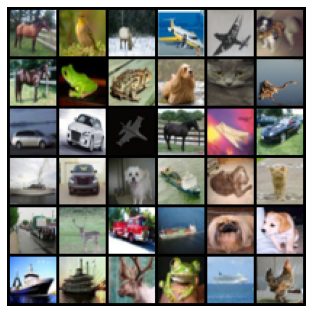

In [4]:
# @title Training configuration 
import datasets


# Build data iterators
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=config.data.uniform_dequantization)
train_iter = iter(train_ds)  # pytype: disable=wrong-arg-types
eval_iter = iter(eval_ds)  # pytype: disable=wrong-arg-types

# Create data normalizer and its inverse
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)

# Save training samples
batch = torch.from_numpy(next(train_iter)['image']._numpy()).to(config.device).float()
batch = batch.permute(0, 3, 1, 2)
print(batch.shape)
plts.save_image(batch, workdir, n=36, pos="vertical", name="data_samples", show=True)

In [5]:
score_model = ddpm.DDPM(config).to(config.device)
score_model = torch.nn.DataParallel(score_model)

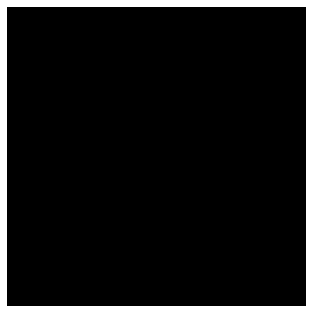

In [9]:
eps =0.0001

t = torch.rand(batch.shape[0], device=batch.device) * (1 - eps) + eps
z = torch.randn_like(batch)
# mean, std = sde.marginal_prob(batch, t)
# perturbed_data = mean + std[:, None, None, None] * z
score = score_model(batch, t)


plts.save_image(score, workdir, n=36, pos="vertical", name="score_samples", show=True)

In [16]:
dp = DDPM()  # defines the diffusion process

# perturbed data 
f, G=dp.discretize(batch, 0.1)


 

AttributeError: ignored

In [5]:
"""
Abstract Class fro the forward and reverse process.
"""

import abc
import torch
import numpy as np


# explain what we need in the diffusion process

class DiffusionProcess(abc.ABC):
    """ Diffusion process abstract class. Functions are designed for a mini-batch of inputs """

    def __init__(self, N):
        """ Construct a Discrete Diffusion process.

        Args:
            N: number of time steps
        """
        super().__init__()
        self.N = N

    @property
    @abc.abstractmethod
    def T(self):
        """End time of the DP."""
        pass

    # @abc.abstractmethod
    # def sde(self, x, t):
    #     pass

    @abc.abstractmethod
    def marginal_prob(self, x, t):
        """ Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
        pass

    @abc.abstractmethod
    def prior_sampling(self, shape):
        """Generate one sample from the prior distribution, $p_T(x)$."""
        pass

    @abc.abstractmethod
    def prior_logp(self, z):
        """Compute log-density of the prior distribution.

        Useful for computing the log-likelihood via probability flow ODE.

        Args:
            z: latent code
        Returns:
            log probability density
        """
        pass

    def discretize(self, x, t):
        """Discretize the SDE in the form : $x_{i+1} = x_i + f_i(x_i) + G_i z_i$

        Useful for reverse diffusion sampling and probability flow sampling.
        Defaults to Euler-Maruyama discretization.

        Args:
            x: a torch tensor
            t: a torch float representing the time step (from o to `self.T`).
        Returns:
            f, G
        """
        dt = 1 / self.N
        drift, diffusion = self.sde(x, t)
        f = drift * dt
        G = diffusion * torch.sqrt(torch.tensor(dt, device=t.device))
        return f, G

    def reverse(self, score_fn, probability_flow=False):
        """ Create the reverse-time SDE/ODE.

        Args:
            score_fn: A time-dependent score-based model that takes x and t and returns the score
            probability_flow: If `True`, create the reverse-time ODE used for probability flow sampling
        Returns:
            the reverse SDE class
        """
        N = self.N
        T = self.T
        sde_fn = self.sde
        discretize_fn = self.discretize

        # Build the class for reverse-time SDE.
        class RSDE(self.__class__):
            def __init__(self):
                self.N = N
                self.probability_flow = probability_flow

            @property
            def T(self):
                return T

            def sde(self, x, t):
                """Creates the drift and diffusion functions for the reverse SDE/ODE."""
                drift, diffusion = sde_fn(x, t)
                score = score_fn(x, t)
                drift = drift - diffusion[:, None, None, None] ** 2 * score * (0.5 if self.probability_flow else 1.)
                # Set the diffusion function to zero for ODEs.
                diffusion = 0. if self.probability_flow else diffusion
                return drift, diffusion

            def discretize(self, x, t):
                f, G = discretize_fn(x, t)
                rev_f = f - G[:, None, None, None] ** 2 * score_fn(x, t) * (0.5 if self.probability_flow else 1.)
                rev_G = torch.zeros_like(G) if self.probability_flow else G
                return rev_f, rev_G

        return RSDE()


1

In [9]:
class DDPM(DiffusionProcess):
    def __init__(self, beta_min=0.2, beta_max=20, N=1000):
        """Construct a Discrete diffusion model.

        Args:
            beta_max: value of beta(0)
            beta_max: value of beta(1)
            N: number of discretization steps
        """
        super().__init__(N)
        self.beta_0 = beta_min
        self.beta_1 = beta_max
        self.N = N
        self.discrete_betas = torch.linspace(beta_min / N, beta_max / N, N)
        self.alphas = 1. - self.discrete_betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_1m_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    @property
    def T(self):
        return 1

    def marginal_prob(self, x, t):
        log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
        mean = torch.exp(log_mean_coeff[:, None, None, None]) * x
        std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
        return mean, std

    def transition_prob(self, x, t):
        """computes the discrete version as DDPM"""
        mean = self.sqrt_alphas_cumprod.to(x.device)[t, None, None, None] * x
        std  = self.sqrt_1m_alphas_cumprod.to(x.device)[t]
        return mean, std

    def prior_sampling(self, shape):
        return torch.randn(*shape)

    def prior_logp(self, z):
        shape = z.shape
        N = np.prod(shape[1:])
        logps = -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1, 2, 3)) / 2.
        return logps

    def discretize(self, x, t):
        """DDPM discretization."""
        timestep = (t * (self.N - 1) / self.T).long()
        beta = self.discrete_betas.to(x.device)[timestep]
        alpha = self.alphas.to(x.device)[timestep]
        sqrt_beta = torch.sqrt(beta)
        f = torch.sqrt(alpha)[:, None, None, None] * x
        G = sqrt_beta
        return f, G
